#### Reading dataset

In [212]:
import pandas as pd
from pymongo import MongoClient
import numpy as np
import matplotlib.pyplot as plt
import re

# Read CSV file into a DataFrame
df = pd.read_csv(r'C:\Users\Lekshmi Sasidharan\Desktop\DAP\PROJECT\Air_Quality.csv')
df

,Unique ID,Indicator ID,Name,Measure,Measure Info,Geo Type Name,Geo Join ID,Geo Place Name,Time Period,Start_Date,Data Value,Region,Latitude Range,Longitude Range,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,121644,386,Ozone (O3),Mean,ppb,CD,101.0,Financial District (CD1),2-Year Summer Average 2009-2010,6/1/2009,22.9,Manhattan South,40.6800 - 40.7900,147.99,NaN,NaN,Measure Info
1,121645,386,Ozone (O3),Mean,ppb,CD,102.0,Greenwich Village and Soho (CD2),2-Year Summer Average 2009-2010,6/1/2009,23.7,Manhattan South,40.6800 - 40.7900,147.99,NaN,NaN,ppb
2,121646,386,Ozone (O3),Mean,ppb,CD,103.0,Lower East Side and Chinatown (CD3),2-Year Summer Average 2009-2010,6/1/2009,24.4,Manhattan South,40.6800 - 40.7900,147.99,NaN,NaN,"per 100,000 adults"
3,121647,386,Ozone (O3),Mean,ppb,CD,104.0,Clinton and Chelsea (CD4),2-Year Summer Average 2009-2010,6/1/2009,23.2,Manhattan South,40.6800 - 40.7900,147.99,NaN,NaN,number
4,121648,386,Ozone (O3),Mean,ppb,CD,105.0,Midtown (CD5),2-Year Summer Average 2009-2010,6/1/2009,17.8,Manhattan Central,40.7000 - 40.8100,147.95,NaN,NaN,Âµg/m3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18040,828369,365,Fine particles (PM 2.5),Mean,mcg/m3,CD,NaN,Long Island City,Winter 2012-13,12/1/2012,9.7,New York City,40.5 to 40.9,148.00,NaN,NaN,NaN
18041,828370,365,Fine particles (PM 2.5),Mean,mcg/m3,CD,NaN,Mount Vernon,Annual Average 2021,1/1/2021,6.3,New York City,40.5 to 40.9,148.00,NaN,NaN,NaN
18042,828371,365,Fine particles (PM 2.5),Mean,mcg/m3,CD,NaN,Jamestown,Annual Average 2012,12/1/2011,8.6,Southern Tier,42.0 to 42.5,153.00,NaN,NaN,NaN
18043,828372,365,Fine particles (PM 2.5),Mean,mcg/m3,CD,NaN,Amherst,Summer 2022,6/1/2022,6.3,Western New York,42.0 to 43.5,157.50,NaN,NaN,NaN


## Exporting data to MongoDB

In [213]:
# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['Datas']
collection = db['Air Quality']

# Convert DataFrame to dictionary records
data = df.to_dict(orient='records')

# Clear existing data in the collection
collection.delete_many({})

# Insert data into MongoDB
for record in data:
    collection.replace_one({'_id': record['Unique ID']}, record, upsert=True)

print("Data written successfully to MongoDB")

Data written successfully to MongoDB


###   Checking and removing Null Values

Number of rows in the MongoDB collection before data filtering operation: 18045
Number of rows deleted due to null or NaN values is 30
Number of rows in the MongoDB collection after null values deletion operation is 18015


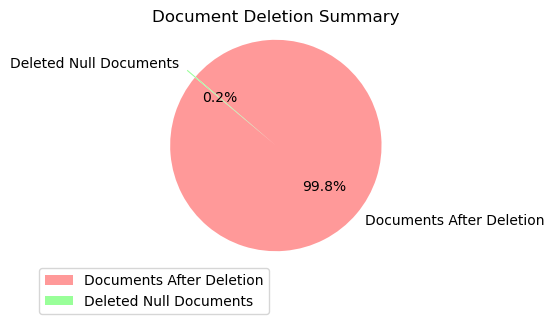

In [214]:
# Print number of rows before any operation
total_before_deletion=collection.count_documents({})
print(f"Number of rows in the MongoDB collection before data filtering operation: {collection.count_documents({})}")

# Count number of documents with null or NaN values in 'Data Value' column
null_count = collection.count_documents({
    "$or": [
        {"Data Value": {"$exists": False}},
        {"Data Value": {"$type": "null"}},
        {"Data Value": {"$type": "double", "$eq": float('nan')}}
    ]
})

# Remove documents with null or NaN values in 'Data Value' column from MongoDB collection
null_deleted_result = collection.delete_many({
    "$or": [
        {"Data Value": {"$exists": False}},
        {"Data Value": {"$type": "null"}},
        {"Data Value": {"$type": "double", "$eq": float('nan')}}
    ]
})

# Check if any documents were deleted
if null_deleted_result.deleted_count > 0:
    print(f"Number of rows deleted due to null or NaN values is {null_count}")
else:
    print("No null or NaN values deleted.")

print(f"Number of rows in the MongoDB collection after null values deletion operation is {collection.count_documents({})}")
total_after_deletion=collection.count_documents({})



# Visualize information in a pie chart
labels = ['Documents After Deletion', 'Deleted Null Documents']
sizes = [total_after_deletion, null_count]
colors = ['#ff9999', '#99ff99']
plt.figure(figsize=(3, 3))  # Adjust the figure size here
explode = (0.1, 0)  # explode the 1st slice
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Document Deletion Summary')
plt.legend(loc='upper right', bbox_to_anchor=(0.5, 0))
plt.show()

#### REMOVING SPECIAL CHARACTERS AND ALPHABETS

Number of rows in the MongoDB collection before data filtering operation: 18015
Number of rows deleted due to special characters or alphabets: 6
Number of rows in the MongoDB collection after removing special characters or alphabets: 18009


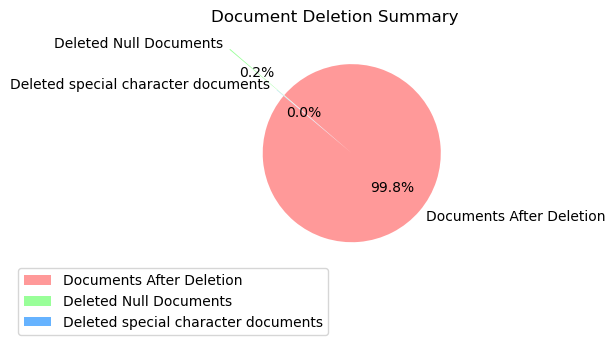

In [215]:
# Print number of rows before any operation
print(f"Number of rows in the MongoDB collection before data filtering operation: {collection.count_documents({})}")

# Count number of documents with special characters or alphabets in 'Data Value' column
special_deleted_count = collection.count_documents({
    "Data Value": {"$regex": r'[^0-9.]'}
})

# Remove documents with special characters or alphabets in 'Data Value' column from MongoDB collection
deleted_result = collection.delete_many({
    "Data Value": {"$regex": r'[^0-9.]'}
})

# Check if any documents were deleted
if deleted_result.deleted_count > 0:
    print(f"Number of rows deleted due to special characters or alphabets: {special_deleted_count}")
else:
    print("No rows deleted due to special characters or alphabets.")
    
print(f"Number of rows in the MongoDB collection after removing special characters or alphabets: {collection.count_documents({})}")
total_after_deletion_2=collection.count_documents({})




# Visualize information in a pie chart
labels = ['Documents After Deletion', 'Deleted Null Documents', 'Deleted special character documents']
sizes = [total_after_deletion_2, null_count, special_deleted_count]
colors = ['#ff9999', '#99ff99', '#66b3ff']
plt.figure(figsize=(3, 3))  # Adjust the figure size here
explode = (0.1, 0.7, 0.0)  # explode the slices
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Document Deletion Summary')
plt.legend(loc='upper right', bbox_to_anchor=(0.5, 0))
plt.show()


### Filtering based on Region and type of hazardous gas present

Filtered data saved successfully into the new collection with 12160 rows

Number of original rows: 18045
Number of discarded rows: 5885


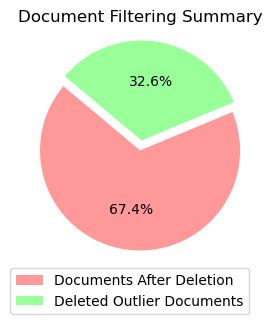

In [216]:
# Count the number of documents in the original collection
#original_count = collection.count_documents({})


# Define a new collection to store filtered data
new_name = 'filtered_collection'

if new_name in db.list_collection_names():
    db.drop_collection(new_name)

new_collection = db['filtered_collection']

# Define list of valid Region values
valid_regions = [
    'Brooklyn Southwest',
    'Queens Northeast',
    'Brooklyn East',
    'Bronx North',
    'Manhattan Central',
    'Manhattan South',
    'Bronx South Central',
    'Queens West',
    'Queens South',
    'New York City Centre',
    'Staten Island'
]

valid_gases = [ 
    'Nitrogen dioxide (NO2)',
    'Fine particles (PM 2.5)' ,
    'Outdoor Air Toxics - Benzene',
    'Outdoor Air Toxics - Formaldehyde' 
]

# Find documents with "Measure Info" key having values "ppb" or "mg/m3" and "Region" key having valid values
filtered_data = collection.find({
    "Name": {"$in": valid_gases},
    "Region": {"$in": valid_regions}
})

# Count the number of documents in the filtered data
#filtered_count = filtered_data.count()

# Insert filtered data into the new collection
new_collection.insert_many(filtered_data)

# Count the number of documents in the filtered data
filtered_count = new_collection.count_documents({})

print(f"Filtered data saved successfully into the new collection with {filtered_count} rows\n")

print(f"Number of original rows: {original_count}")
print(f"Number of discarded rows: {original_count - filtered_count}")

outlier_rows=original_count - filtered_count



# Visualize information in a pie chart
labels = ['Documents After Deletion', 'Deleted Outlier Documents']
sizes = [filtered_count, outlier_rows]
colors = ['#ff9999', '#99ff99']
plt.figure(figsize=(3, 3))  # Adjust the figure size here
explode = (0.1, 0)  # explode the 1st slice
plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Document Filtering Summary')
plt.legend(labels=labels, loc='upper right', bbox_to_anchor=(1, 0))
plt.show()

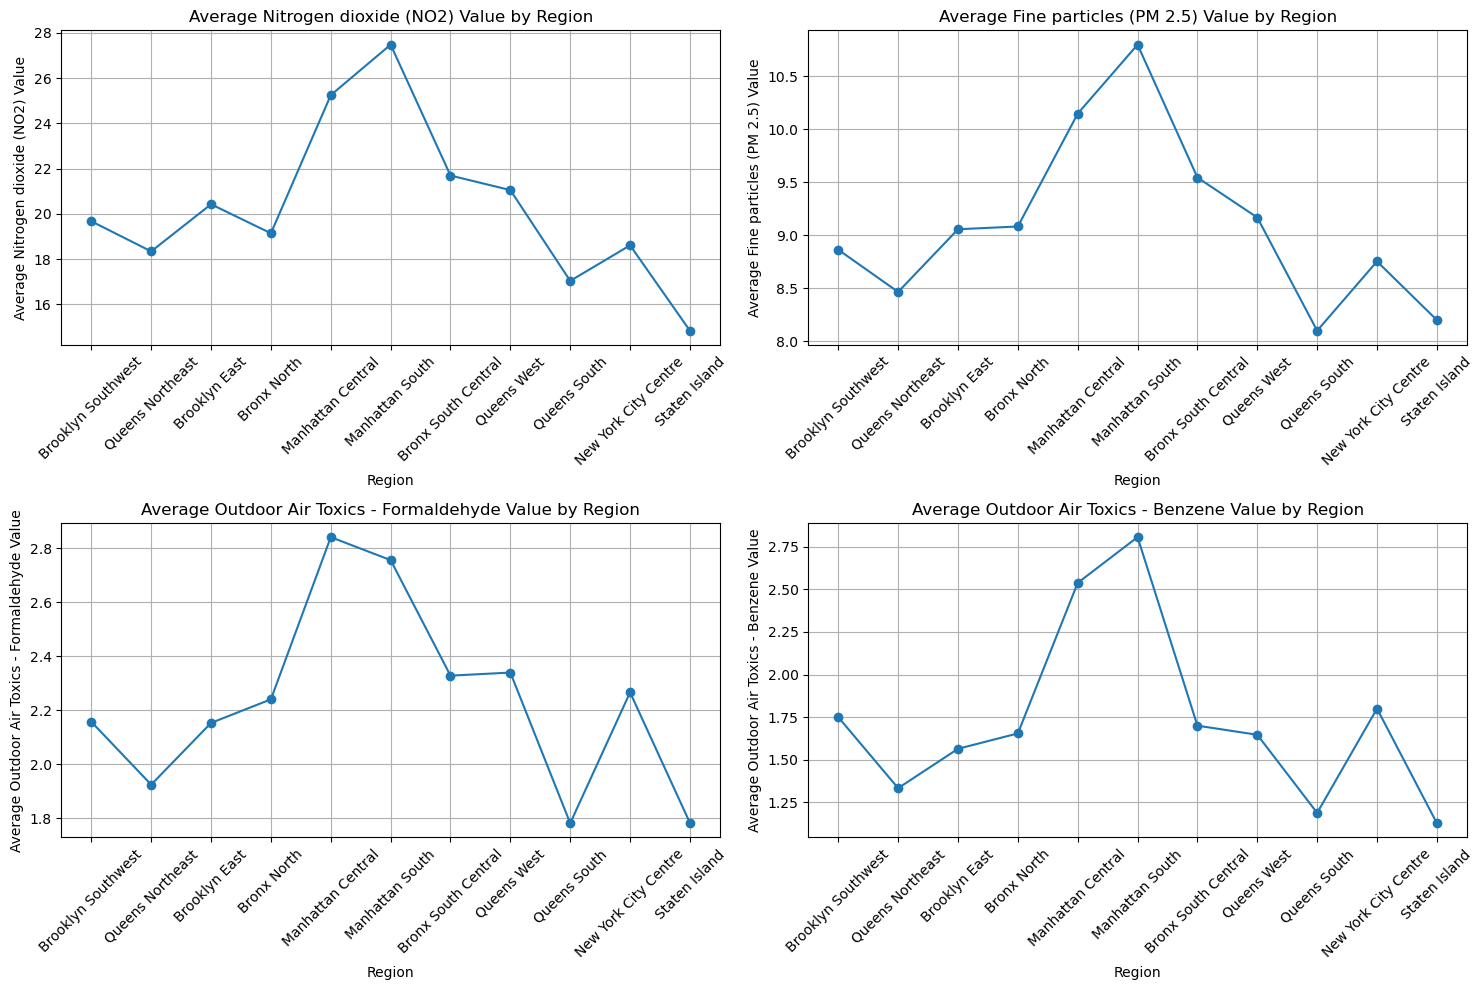

In [217]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize dictionaries to store data values for each region and each gas
gas_data_values = {gas: {region: [] for region in valid_regions} for gas in ['Nitrogen dioxide (NO2)', 'Fine particles (PM 2.5)', 'Outdoor Air Toxics - Formaldehyde', 'Outdoor Air Toxics - Benzene']}

# Query MongoDB for documents matching valid regions
for region in valid_regions:
    cursor = collection.find({"Region": region})
    for doc in cursor:
        name_value = doc.get('Name', None)
        data_value = doc.get('Data Value', None)
        if name_value == 'Nitrogen dioxide (NO2)':
            gas_data_values['Nitrogen dioxide (NO2)'][region].append(data_value)
        elif name_value == 'Fine particles (PM 2.5)':
            gas_data_values['Fine particles (PM 2.5)'][region].append(data_value)
        elif name_value == 'Outdoor Air Toxics - Formaldehyde':
            gas_data_values['Outdoor Air Toxics - Formaldehyde'][region].append(data_value)
        elif name_value == 'Outdoor Air Toxics - Benzene':
            gas_data_values['Outdoor Air Toxics - Benzene'][region].append(data_value)

# Convert values to numerical data type
gas_data_values_numeric = {gas: {region: [float(value) for value in values] for region, values in gas_data_values[gas].items()} for gas in gas_data_values}

# Plot the graphs as a matrix
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
for i, gas_name in enumerate(['Nitrogen dioxide (NO2)', 'Fine particles (PM 2.5)', 'Outdoor Air Toxics - Formaldehyde', 'Outdoor Air Toxics - Benzene']):
    row = i // 2
    col = i % 2
    avg_gas_values = {region: np.mean(values) for region, values in gas_data_values_numeric[gas_name].items()}    
    axs[row, col].plot(list(avg_gas_values.keys()), list(avg_gas_values.values()), marker='o')
    axs[row, col].set_title(f'Average {gas_name} Value by Region')
    axs[row, col].set_xlabel('Region')
    axs[row, col].set_ylabel(f'Average {gas_name} Value')
    axs[row, col].grid(True)
    axs[row, col].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()


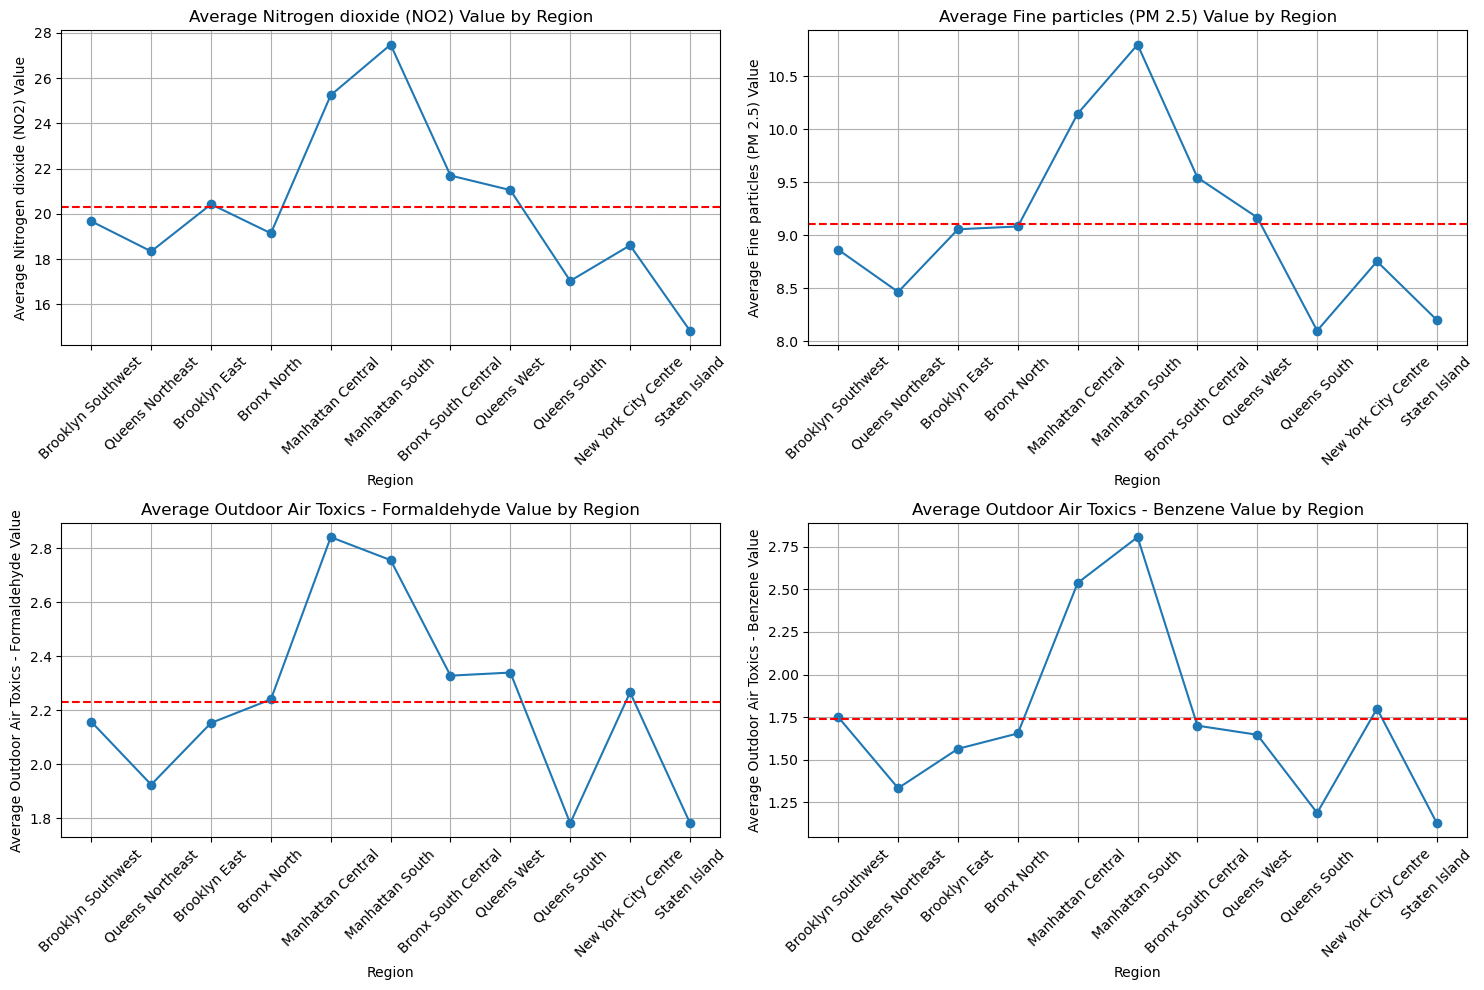

In [218]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize dictionaries to store data values for each region and each gas
gas_data_values = {gas: {region: [] for region in valid_regions} for gas in ['Nitrogen dioxide (NO2)', 'Fine particles (PM 2.5)', 'Outdoor Air Toxics - Formaldehyde', 'Outdoor Air Toxics - Benzene']}

# Query MongoDB for documents matching valid regions
for region in valid_regions:
    cursor = collection.find({"Region": region})
    for doc in cursor:
        name_value = doc.get('Name', None)
        data_value = doc.get('Data Value', None)
        if name_value == 'Nitrogen dioxide (NO2)':
            gas_data_values['Nitrogen dioxide (NO2)'][region].append(data_value)
        elif name_value == 'Fine particles (PM 2.5)':
            gas_data_values['Fine particles (PM 2.5)'][region].append(data_value)
        elif name_value == 'Outdoor Air Toxics - Formaldehyde':
            gas_data_values['Outdoor Air Toxics - Formaldehyde'][region].append(data_value)
        elif name_value == 'Outdoor Air Toxics - Benzene':
            gas_data_values['Outdoor Air Toxics - Benzene'][region].append(data_value)

# Convert values to numerical data type
gas_data_values_numeric = {gas: {region: [float(value) for value in values] for region, values in gas_data_values[gas].items()} for gas in gas_data_values}

# Threshold values for each gas
threshold_values = {'Nitrogen dioxide (NO2)': 20.3,
                    'Fine particles (PM 2.5)': 9.11,
                    'Outdoor Air Toxics - Formaldehyde': 2.23,
                    'Outdoor Air Toxics - Benzene': 1.74}

# Plot the graphs as a matrix
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
for i, gas_name in enumerate(['Nitrogen dioxide (NO2)', 'Fine particles (PM 2.5)', 'Outdoor Air Toxics - Formaldehyde', 'Outdoor Air Toxics - Benzene']):
    row = i // 2
    col = i % 2
    avg_gas_values = {region: np.mean(values) for region, values in gas_data_values_numeric[gas_name].items()}    
    axs[row, col].plot(list(avg_gas_values.keys()), list(avg_gas_values.values()), marker='o')
    axs[row, col].set_title(f'Average {gas_name} Value by Region')
    axs[row, col].set_xlabel('Region')
    axs[row, col].set_ylabel(f'Average {gas_name} Value')
    axs[row, col].grid(True)
    axs[row, col].tick_params(axis='x', rotation=45)
    
    # Draw horizontal line at threshold value
    axs[row, col].axhline(y=threshold_values[gas_name], color='r', linestyle='--')

# Adjust layout
plt.tight_layout()
plt.show()


### Plotting of air quality based on specific gases

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U4'), dtype('<U4')) -> None

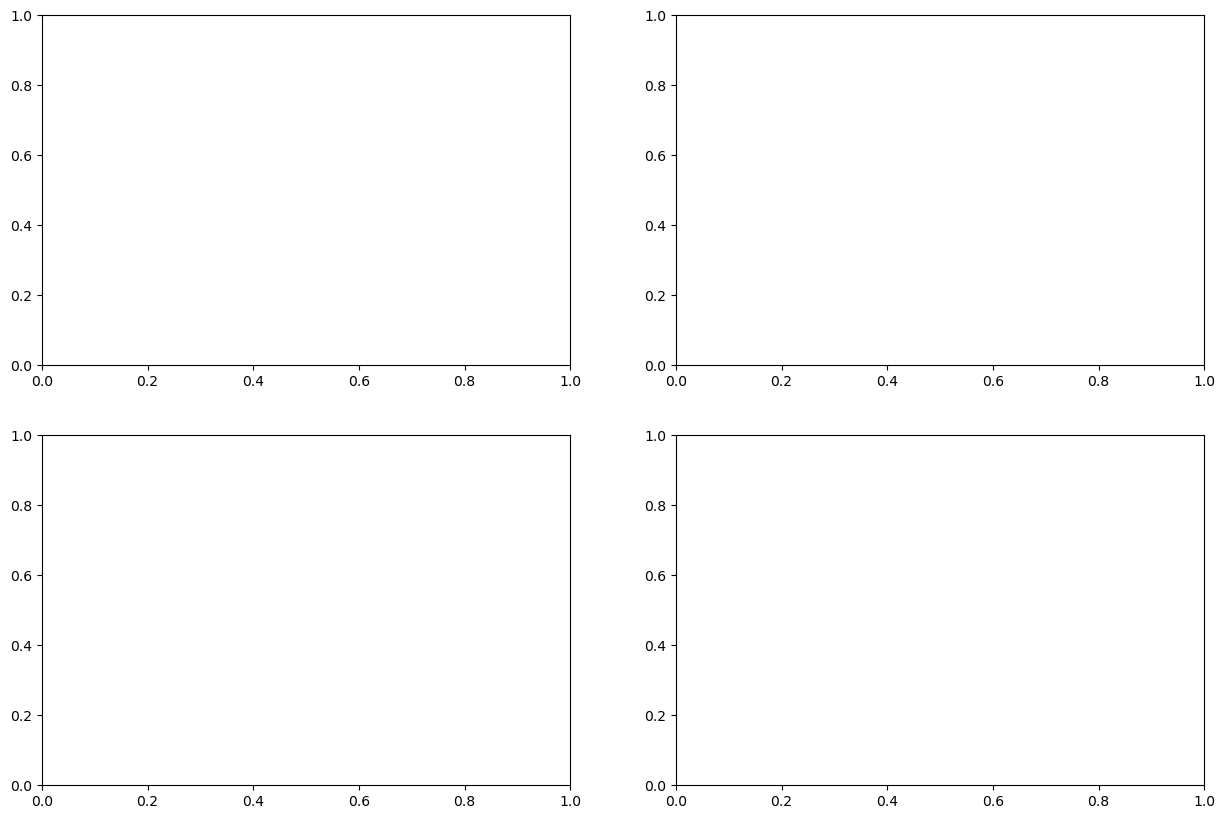

In [202]:
# Initialize dictionaries to store data values for each region and each gas
gas_data_values = {gas: {region: [] for region in valid_regions} for gas in ['Nitrogen dioxide (NO2)', 'Fine particles (PM 2.5)', 'Outdoor Air Toxics - Formaldehyde', 'Outdoor Air Toxics - Benzene']}

# Query MongoDB for documents matching valid regions
for region in valid_regions:
    cursor = collection.find({"Region": region})
    for doc in cursor:
        name_value = doc.get('Name', None)
        data_value = doc.get('Data Value', None)
        if name_value == 'Nitrogen dioxide (NO2)':
            gas_data_values['Nitrogen dioxide (NO2)'][region].append(data_value)
        elif name_value == 'Fine particles (PM 2.5)':
            gas_data_values['Fine particles (PM 2.5)'][region].append(data_value)
        elif name_value == 'Outdoor Air Toxics - Formaldehyde':
            gas_data_values['Outdoor Air Toxics - Formaldehyde'][region].append(data_value)
        elif name_value == 'Outdoor Air Toxics - Benzene':
            gas_data_values['Outdoor Air Toxics - Benzene'][region].append(data_value)

# Plot the graphs as a matrix
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
for i, gas_name in enumerate(['Nitrogen dioxide (NO2)', 'Fine particles (PM 2.5)', 'Outdoor Air Toxics - Formaldehyde', 'Outdoor Air Toxics - Benzene']):
    row = i // 2
    col = i % 2
    avg_gas_values = {region: np.mean(values) for region, values in gas_data_values[gas_name].items()}    
    axs[row, col].plot(list(avg_gas_values.keys()), list(avg_gas_values.values()), marker='o')
    axs[row, col].set_title(f'Average {gas_name} Value by Region')
    axs[row, col].set_xlabel('Region')
    axs[row, col].set_ylabel(f'Average {gas_name} Value')
    axs[row, col].grid(True)
    axs[row, col].tick_params(axis='x', rotation=45)

# Adjust layout
#plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Differentiating toxic and good quality air

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U4'), dtype('<U4')) -> None

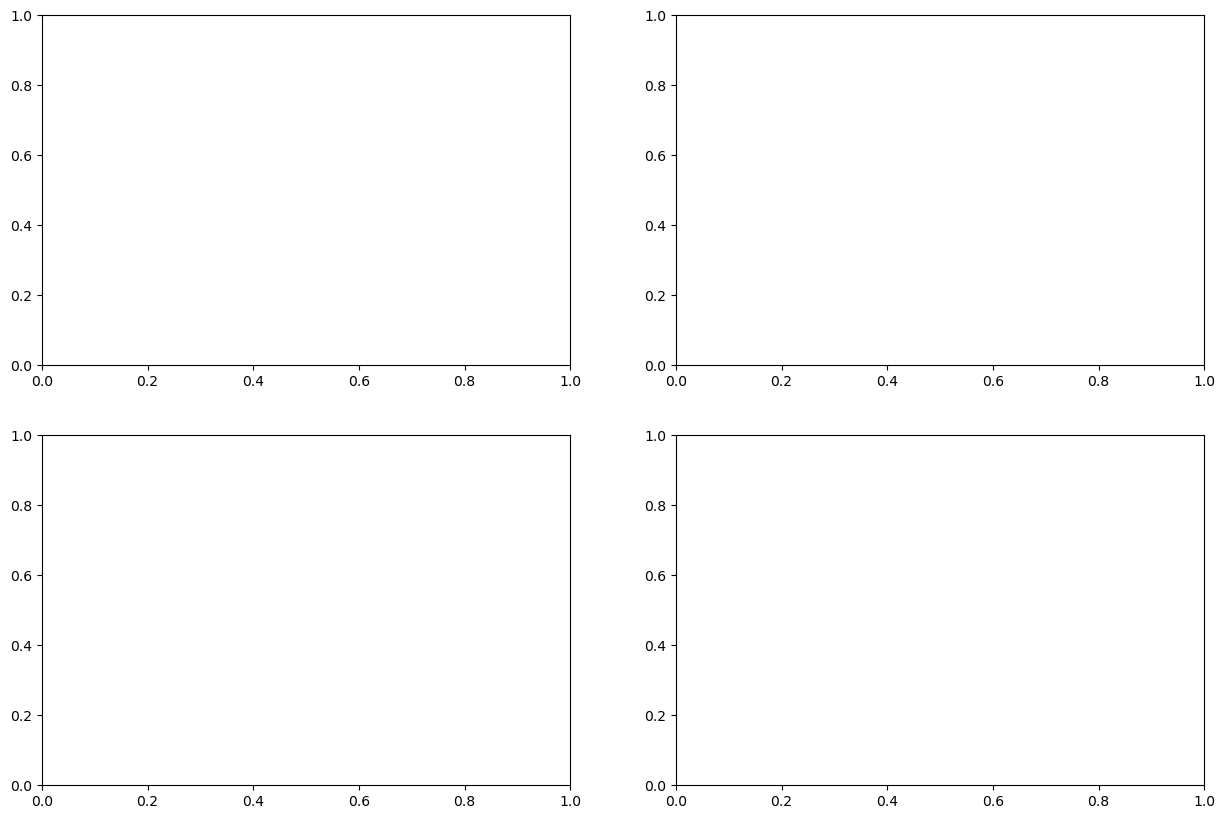

In [207]:
# Define the y-values for the horizontal lines
threshold_values = {'Nitrogen dioxide (NO2)': 20.3,
                    'Fine particles (PM 2.5)': 9.11,
                    'Outdoor Air Toxics - Formaldehyde': 2.23,
                    'Outdoor Air Toxics - Benzene': 1.74}

# Plot the graphs as a matrix
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
for i, gas_name in enumerate(['Nitrogen dioxide (NO2)', 'Fine particles (PM 2.5)', 'Outdoor Air Toxics - Formaldehyde', 'Outdoor Air Toxics - Benzene']):
    row = i // 2
    col = i % 2
    avg_gas_values = {region: np.mean(values) for region, values in gas_data_values[gas_name].items()}    
    axs[row, col].plot(list(avg_gas_values.keys()), list(avg_gas_values.values()), marker='o')
    axs[row, col].set_title(f'Average {gas_name} Value by Region')
    axs[row, col].set_xlabel('Region')
    axs[row, col].set_ylabel(f'Average {gas_name} Value')
    axs[row, col].grid(True)
    axs[row, col].tick_params(axis='x', rotation=45)
    
    # Draw horizontal line
    axs[row, col].axhline(y=threshold_values[gas_name], color='r', linestyle='--')

# Adjust layout
plt.tight_layout()
plt.show()
